In [1]:
!pwd

/home/ubuntu/projects/ip-dual-encoder-factorization-machine/notebooks/step3_model


In [3]:
# c6a.4xlarge
# ml.p3.2xlarge
# ml.p3.8xlarge


In [4]:
# !pip install --upgrade --no-cache-dir jupyter ipywidgets pandas torch transformers datasets s3fs tqdm tensorboard mlflow torchmetrics
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix


In [5]:
import pandas as pd
import numpy as np
import math
from pprint import pprint
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
from datasets import load_dataset, Dataset, DatasetDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import mlflow

print(torch.__version__)
print(mlflow.__version__)

2.0.1+cu117
2.4.1


In [6]:
print(torch.cuda.device_count())
# torch.backends.cuda.matmul.allow_tf32 = True # True
torch.backends.cuda.matmul.allow_tf32

4


False

In [7]:
# running_on_aws = False
running_on_aws = True

# Load the processed data from step 2 (optional)
Skip this part and start from `Load the DatasetDict from S3`

In [8]:
proj_root_path = os.path.dirname(os.path.dirname(os.getcwd())) if running_on_aws else '/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/'

proj_root_path

'/home/ubuntu/projects/ip-dual-encoder-factorization-machine'

In [11]:
# data_path = '/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/notebooks/input_processed/final'  # local path
# data_dict = {ds: pd.read_json(os.path.join(data_path, f'{ds}_data.json')).sample(64) for ds in ['train', 'valid', 'test']}

data_path = 's3://tyler-s3-bucket/other/interview-projects/seek/input_processed_output/' if running_on_aws else '/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/data/input_processed_output/'
print(data_path)

df_dtypes = {
    'event_datetime': str,
    'resume_id_encoded': np.int32,
    'job_id_sequence': str,
    'job_id_next': np.int32,
    'class': np.int8,
    'title': str,
    'abstract': str,
    'location': str,
    'classification': str
}

dataframe_dict = {
    ds: pd.read_json(os.path.join(data_path, f'{ds}_data.json'), dtype=df_dtypes) for ds in ['train', 'valid', 'test']
}

s3://tyler-s3-bucket/other/interview-projects/seek/input_processed_output/


In [12]:
display(dataframe_dict['train'].dtypes)
dataframe_dict['train']

event_datetime       object
resume_id_encoded     int32
job_id_sequence      object
job_id_next           int32
class                  int8
title                object
abstract             object
location             object
classification       object
dtype: object

,event_datetime,resume_id_encoded,job_id_sequence,job_id_next,class,title,abstract,location,classification
0,2021-05-01 00:00:07,1,[23106],17225,1,"Programme Manager, healthAlliance","Permanent, Full Time Role Based in Penrose",Auckland,Information & Communication Technology
1,2021-05-01 00:00:07,1,"[23106, 17225]",939,1,Office Administrator,Excellent opportunity for a proactive PA/Offic...,Sydney,Administration & Office Support
2,2021-05-01 00:00:07,1,"[23106, 17225, 939]",24851,1,2IC Retail Career Opportunity - Liverpool Store,High profile Homemaker Retailer specialising i...,Sydney,Retail & Consumer Products
3,2021-05-01 00:00:07,1,"[23106, 17225, 939, 24851]",20479,1,Maternal & Child Health Nurse,Yarra City Council is looking for enthusiastic...,Melbourne,Government & Defence
4,2021-05-01 00:00:07,1,"[23106, 17225, 939, 24851, 20479]",44011,1,Construction All Rounder / Labourer,Construction All Rounder/Labourer - Fulltime C...,Toowoomba & Darling Downs,Trades & Services
...,...,...,...,...,...,...,...,...,...
1344081,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",14325,0,REAL ESTATE SALES - STAR PERFORMER WANTED - BE...,Berwick Leading Agents Expected Income Earning...,Melbourne,Sales
1344082,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",27777,0,Litigation Support Clerk (afternoon shift),Afternoon shift loading $$,Sydney,Administration & Office Support
1344083,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",45281,0,Team Administrator,Dynamic role working within a passionate and s...,Auckland,Administration & Office Support
1344084,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",43618,0,Retail Second In Charge - David Jones Chadston...,"Join Seed on your exciting new journey; Help, ...",Melbourne,Retail & Consumer Products


In [6]:
# for k, v in dataframe_dict.items():
#     print(k)
#     display(v.info(memory_usage="deep"))

In [13]:
dataset_dict = DatasetDict({k: Dataset.from_pandas(v, split=k, preserve_index=False) for k, v in dataframe_dict.items()})
dataset_dict = dataset_dict.remove_columns(['event_datetime'])
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'class', 'title', 'abstract', 'location', 'classification'],
        num_rows: 1344086
    })
    valid: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'class', 'title', 'abstract', 'location', 'classification'],
        num_rows: 168038
    })
    test: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'class', 'title', 'abstract', 'location', 'classification'],
        num_rows: 187480
    })
})

In [14]:
dataset_dict['train'].features

{'resume_id_encoded': Value(dtype='int32', id=None),
 'job_id_sequence': Value(dtype='string', id=None),
 'job_id_next': Value(dtype='int32', id=None),
 'class': Value(dtype='int8', id=None),
 'title': Value(dtype='string', id=None),
 'abstract': Value(dtype='string', id=None),
 'location': Value(dtype='string', id=None),
 'classification': Value(dtype='string', id=None)}

In [15]:
MAX_LEN = 512

# https://huggingface.co/jjzha/jobbert-base-cased
checkpoint = 'bert-base-cased' # 'jjzha/jobbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_length = MAX_LEN
tokenizer.model_max_length

512

In [16]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [17]:
def tokenize(batch):
    """
    Tokenizer function for job text columns. Postponed the padding part to batching by DataLoader.
    :param batch:
    :return:
    """
    # return tokenizer(batch["title"], batch["abstract"], return_tensors='pt', truncation=True, max_length=MAX_LEN, padding='max_length')
    return tokenizer(batch["title"], batch["abstract"], truncation=True, max_length=MAX_LEN, padding=False)

In [18]:
dataset_dict.cache_files

{'train': [], 'valid': [], 'test': []}

In [21]:
if running_on_aws:
    # !rm -r "/home/ec2-user/projects/ip-dual-encoder-factorization-machine/data/tmp_data/"
    !rm -r /home/ubuntu/projects/ip-dual-encoder-factorization-machine/data/tmp_data/
else:
    !rm -r "/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/data/tmp_data/"

In [22]:
proj_root_path

'/home/ubuntu/projects/ip-dual-encoder-factorization-machine'

In [23]:
# p3.8xlarge: 32 CPUs

map_batch_size = 15 #6
num_proc = 15 #6
writer_batch_size = 1000 #500

# cache_file_path = f'{proj_root_path}/data/tmp_data'
cache_paths = [
    f'{proj_root_path}/data',
    f'{proj_root_path}/data/tmp_data',
    f'{proj_root_path}/data/tmp_data/tokenize',
    # f'{proj_root_path}/tmp_data/pad_job_id_sequence'
]
for path in cache_paths:
    try:
        os.mkdir(path)
    except OSError as error:
        print(error)

dataset_dict = dataset_dict.map(
    tokenize,
    batched=True,
    batch_size=map_batch_size,
    num_proc=num_proc,
    cache_file_names={k: f'{cache_paths[-1]}/{k}_cache.arrow' for k in dataset_dict.keys()},
    writer_batch_size=writer_batch_size,
    desc='tokenize'
)

print('Map execution completed.')

[Errno 17] File exists: '/home/ubuntu/projects/ip-dual-encoder-factorization-machine/data'


tokenize (num_proc=15):   0%|          | 0/1344086 [00:00<?, ? examples/s]

tokenize (num_proc=15):   0%|          | 0/168038 [00:00<?, ? examples/s]

tokenize (num_proc=15):   0%|          | 0/187480 [00:00<?, ? examples/s]

Map execution completed.


In [25]:
dataset_dict['train'].select(range(10)).to_pandas()

,resume_id_encoded,job_id_sequence,job_id_next,class,title,abstract,location,classification,input_ids,token_type_ids,attention_mask
0,1,[23106],17225,1,"Programme Manager, healthAlliance","Permanent, Full Time Role Based in Penrose",Auckland,Information & Communication Technology,"[101, 11512, 7165, 117, 2332, 1592, 6473, 3923...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,"[23106, 17225]",939,1,Office Administrator,Excellent opportunity for a proactive PA/Offic...,Sydney,Administration & Office Support,"[101, 3060, 19483, 102, 25764, 3767, 1111, 170...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1,"[23106, 17225, 939]",24851,1,2IC Retail Career Opportunity - Liverpool Store,High profile Homemaker Retailer specialising i...,Sydney,Retail & Consumer Products,"[101, 123, 9741, 11336, 11154, 17062, 9126, 43...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"[23106, 17225, 939, 24851]",20479,1,Maternal & Child Health Nurse,Yarra City Council is looking for enthusiastic...,Melbourne,Government & Defence,"[101, 25702, 10449, 1348, 111, 6405, 3225, 174...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,1,"[23106, 17225, 939, 24851, 20479]",44011,1,Construction All Rounder / Labourer,Construction All Rounder/Labourer - Fulltime C...,Toowoomba & Darling Downs,Trades & Services,"[101, 6568, 1398, 4200, 1200, 120, 4560, 1200,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,1,"[23106, 17225, 939, 24851, 20479, 44011]",37496,1,Casual Café All-rounder in North Rocks,A cafe in North Rocks is seeking a casual Café...,Sydney,Hospitality & Tourism,"[101, 140, 2225, 4746, 21036, 1398, 118, 1668,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,1,"[23106, 17225, 939, 24851, 20479, 44011, 37496]",10857,1,Store Manager - North Eastern Suburbs,"We are seeking an accomplished, energetic pers...",Melbourne,Retail & Consumer Products,"[101, 10422, 7165, 118, 1456, 2882, 12859, 214...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,1,"[23106, 17225, 939, 24851, 20479, 44011, 37496...",1610,1,Retail Store Manager - Sage Collective - Westf...,Sage Collective is currently looking for an in...,"Newcastle, Maitland & Hunter",Retail & Consumer Products,"[101, 11336, 11154, 10422, 7165, 118, 15204, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,1,"[23106, 17225, 939, 24851, 20479, 44011, 37496...",28182,1,Drama/Humanities/Generalist Classroom Teacher,The classroom teacher classification comprises...,Melbourne,Education & Training,"[101, 8020, 120, 14860, 120, 1615, 1776, 3699,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,1,"[23106, 17225, 939, 24851, 20479, 44011, 37496...",40665,1,Field Service Coordinator,"Field Service Coordinator position available, ...",Brisbane,Engineering,"[101, 3479, 2516, 25561, 102, 3479, 2516, 2556...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [26]:
# dataset_dict.cache_files

In [27]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'class', 'title', 'abstract', 'location', 'classification', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1344086
    })
    valid: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'class', 'title', 'abstract', 'location', 'classification', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 168038
    })
    test: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'class', 'title', 'abstract', 'location', 'classification', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 187480
    })
})

In [28]:
keeping_column_names = [
    'input_ids',
    'attention_mask',
    'token_type_ids',
    'job_id_next',
    'resume_id_encoded',
    'job_id_sequence',
    # 'padded_job_id_sequences',
    # 'padded_job_id_sequences_padding_mask',
    'class'
]
removing_column_names = [x for x in dataset_dict['train'].column_names if x not in keeping_column_names]

dataset_dict = dataset_dict.remove_columns(removing_column_names)
dataset_dict = dataset_dict.rename_column('class', 'labels')

# dataset_dict.set_format(type='torch')
# dataset_dict = dataset_dict.with_format(type='torch')

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1344086
    })
    valid: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 168038
    })
    test: Dataset({
        features: ['resume_id_encoded', 'job_id_sequence', 'job_id_next', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 187480
    })
})

In [29]:
dataset_dict['train'].format

{'type': None,
 'format_kwargs': {},
 'columns': ['resume_id_encoded',
  'job_id_sequence',
  'job_id_next',
  'labels',
  'input_ids',
  'token_type_ids',
  'attention_mask'],
 'output_all_columns': False}

# Save the DatasetDict to S3

In [30]:
dataset_dict_s3_path = 's3://tyler-s3-bucket/other/interview-projects/seek/final_dataset_dict/'
# dataset_dict_s3_path = f'{proj_root_path}/data/tmp_data/final_dataset_dict'

dataset_dict.save_to_disk(dataset_dict_path=dataset_dict_s3_path)

Saving the dataset (0/2 shards):   0%|          | 0/1344086 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/168038 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/187480 [00:00<?, ? examples/s]

# Load the DatasetDict from S3

In [31]:
# Load the DatasetDict from S3
dataset_dict_s3_path = 's3://tyler-s3-bucket/other/interview-projects/seek/final_dataset_dict/'
# dataset_dict_s3_path = f'{proj_root_path}/data/tmp_data/final_dataset_dict'

dataset_dict = DatasetDict.load_from_disk(dataset_dict_path=dataset_dict_s3_path)

In [32]:
dataset_dict['test'].features

{'resume_id_encoded': Value(dtype='int32', id=None),
 'job_id_sequence': Value(dtype='string', id=None),
 'job_id_next': Value(dtype='int32', id=None),
 'labels': Value(dtype='int8', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

----------------

# Check

In [ ]:
torch.cuda.device_count()

1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
device

device(type='cuda')

# Check Noam LR scheduler

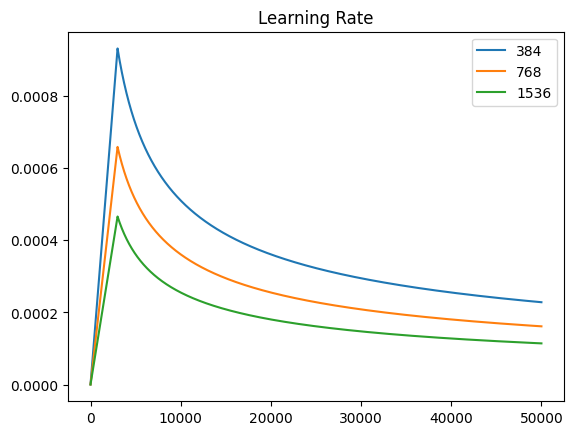

In [3]:
import matplotlib.pyplot as plt
import numpy as np
d_model = 768

def calc_lr(step, dim_embed, warmup_steps):
    return dim_embed ** (-0.5) * min(step ** (-0.5), step * warmup_steps ** (-1.5))

lr_scheduler_scale_factor = 1 #0.9  # 1.0
WARMUP_STEPS = 3000 #10000

# lr_scheduler_scale_factor =0.9  # 1.0
# WARMUP_STEPS = 6000 #10000

_total_steps = 50_000
_warmup_steps = WARMUP_STEPS
_dim_models = [int(d_model / 2), d_model, d_model * 2]
plt.plot(
    np.arange(1, _total_steps),
    [
        [lr_scheduler_scale_factor * calc_lr(i, _dim_model, _warmup_steps) for _dim_model in _dim_models]
        for i in range(1, _total_steps)
    ]
)
plt.legend(_dim_models)
plt.title("Learning Rate")
plt.show()

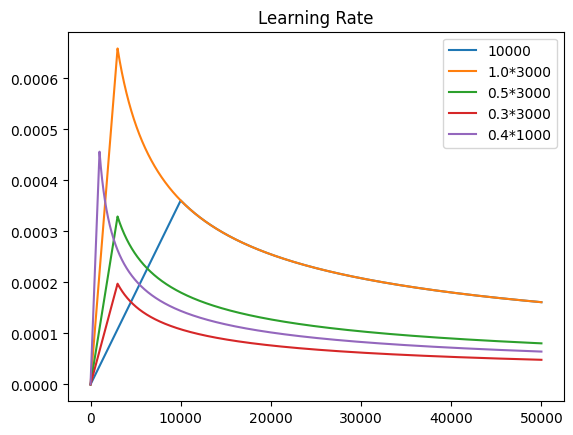

In [8]:
import matplotlib.pyplot as plt
import numpy as np
d_model = 768

def calc_lr(step, dim_embed, warmup_steps):
    return dim_embed ** (-0.5) * min(step ** (-0.5), step * warmup_steps ** (-1.5))

lr_scheduler_scale_factor = 1 #0.9  # 1.0
WARMUP_STEPS = 3000 #10000

# lr_scheduler_scale_factor =0.9  # 1.0
# WARMUP_STEPS = 6000 #10000

_total_steps = 50_000  # 50_000
_warmup_steps = WARMUP_STEPS
# _dim_models = [int(d_model / 2), d_model, d_model * 2]
plt.plot(
    np.arange(1, _total_steps),
    [
        [
            # 1.0 * calc_lr(i, 768, 3000),
            1.0 * calc_lr(i, 768, 10000),
            # 1.0 * calc_lr(i, 768, 15000),
            # # 0.7 * calc_lr(i, 768, 15000),
            1.0 * calc_lr(i, 768, 3000),
            0.5 * calc_lr(i, 768, 3000),
            0.3 * calc_lr(i, 768, 3000),
            # 1.0 * calc_lr(i, 768, 1000)
            0.4 * calc_lr(i, 768, 1000),
        ]
        for i in range(1, _total_steps)
    ]
)
plt.legend([
    # 3000,
    10000,
    # 15000,
    # # '0.7*15000',
    '1.0*3000',
    '0.5*3000',
    '0.3*3000',
    '0.4*1000'
])
plt.title("Learning Rate")
plt.show()